In [157]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import time
import datetime
from dateutil import parser
import matplotlib.dates as mdates
import matplotlib.ticker as plticker

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.losses import Huber, LogCosh

# np.set_printoptions(threshold=np.inf)


In [85]:
data = pd.read_csv("./datasets/data.csv")
data.drop(data.tail(1).index,inplace=True)
data = data.set_index('timestamp')
data

,YFI price,YFI market cap,YFI total volume,BTC price,BTC market cap,BTC total volume,ETH price,ETH market cap,ETH total volume
timestamp,,,,,,,,,
2022-01-01 00:01:39,33581.023746,1.196264e+09,4.139663e+08,46880.270561,8.863330e+11,2.578711e+10,3735.556516,4.439400e+11,1.431206e+10
2022-01-01 01:02:28,33513.319087,1.197463e+09,4.134295e+08,46907.544324,8.870402e+11,2.581655e+10,3732.342737,4.440541e+11,1.404572e+10
2022-01-01 02:04:08,33777.401593,1.202573e+09,4.195212e+08,46874.726169,8.867040e+11,2.572329e+10,3726.551528,4.432195e+11,1.391855e+10
2022-01-01 03:03:58,33941.572877,1.215497e+09,4.244835e+08,47372.201889,8.980567e+11,2.626943e+10,3747.034821,4.466241e+11,1.411753e+10
2022-01-01 04:05:04,33377.033435,1.193235e+09,4.221231e+08,47128.848463,8.930874e+11,2.628068e+10,3716.670188,4.421958e+11,1.414777e+10
...,...,...,...,...,...,...,...,...,...
2022-12-21 21:00:00,5555.877012,1.822105e+08,1.079974e+07,16816.853701,3.231279e+11,1.606277e+10,1213.343161,1.460393e+11,4.086535e+09
2022-12-22 21:00:00,5609.875662,1.836835e+08,1.205294e+07,16824.790162,3.235193e+11,1.784783e+10,1217.852550,1.467410e+11,5.190165e+09
2022-12-23 21:00:00,5501.863944,1.802692e+08,1.432631e+07,16791.455439,3.230134e+11,1.676539e+10,1220.701745,1.470698e+11,4.777026e+09


In [214]:
scaler = MinMaxScaler(feature_range=(0, 1))
features_not_used = [3,4,5,6,7,8]
data2=np.delete(data.values,features_not_used,1)
dataset = scaler.fit_transform(data2)
num_of_features = len(data.columns)-len(features_not_used)
print('Number of features', num_of_features)

Number of features 3


In [215]:
expr_name = 'expr_1'
look_back = 700
lstm_layers = 32
epochs=20
batch_size=32

In [216]:
train_size_percent = 0.8
pred_col = data.columns.get_loc('YFI price')

# function to split the data
def create_dataset(dataset, pred_col, look_back=1):
  dataX, dataY = [], []
  for i in range(len(dataset)-look_back-1):
    a = dataset[i:(i+look_back), :]
    dataX.append(a)
    dataY.append(dataset[i + look_back, pred_col])
  return np.array(dataX), np.array(dataY)


train_size = int(len(dataset) * train_size_percent)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]

trainX, trainY = create_dataset(train, pred_col, look_back=look_back)
testX, testY = create_dataset(test, pred_col, look_back=look_back)
# reshape input to be  [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], look_back, num_of_features))
testX = np.reshape(testX, (testX.shape[0],look_back, num_of_features))


print('Training dataset length ', len(train))
print('Testing dataset length ', len(test))
print('look_back ', look_back)

Training dataset length  3593
Testing dataset length  899
look_back  700


In [217]:
# create and fit the LSTM network

model = Sequential()
model.add(LSTM(lstm_layers, input_shape=(look_back,num_of_features)))
model.add(Dense(1))
#model.compile(loss='mean_squared_error', optimizer='adam')
model.compile(loss=LogCosh(), optimizer='adam')
history= model.fit(trainX, trainY,validation_split=0.10, epochs=epochs, batch_size=batch_size,shuffle=False)

Epoch 1/20
82/82 [==============================] - 25s 273ms/step - loss: 0.0081 - val_loss: 8.3610e-04
Epoch 2/20
82/82 [==============================] - 22s 265ms/step - loss: 0.0014 - val_loss: 5.9021e-04
Epoch 3/20
82/82 [==============================] - 21s 260ms/step - loss: 7.8882e-04 - val_loss: 4.3766e-04
Epoch 4/20
82/82 [==============================] - 22s 265ms/step - loss: 4.7556e-04 - val_loss: 2.7407e-04
Epoch 5/20
82/82 [==============================] - 21s 262ms/step - loss: 3.0969e-04 - val_loss: 1.3479e-04
Epoch 6/20
82/82 [==============================] - 22s 265ms/step - loss: 2.1322e-04 - val_loss: 5.0074e-05
Epoch 7/20
82/82 [==============================] - 22s 265ms/step - loss: 1.5072e-04 - val_loss: 1.7579e-05
Epoch 8/20
82/82 [==============================] - 21s 261ms/step - loss: 1.0731e-04 - val_loss: 1.3838e-05
Epoch 9/20
82/82 [==============================] - 21s 252ms/step - loss: 7.8365e-05 - val_loss: 1.8974e-05
Epoch 10/20
82/82 [========

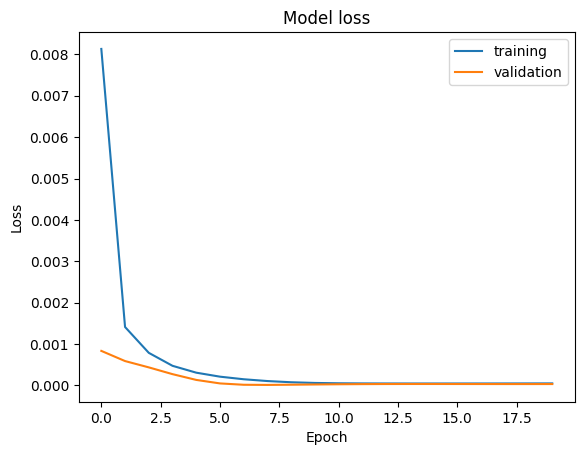

In [218]:
# Plot training
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

In [219]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# Get something which has as many features as dataset
trainPredict_extended = np.zeros((len(trainPredict),num_of_features))
# Put the predictions there
trainPredict_extended[:,pred_col] = trainPredict[:,0]
# Inverse transform it and select the 3rd column.
trainPredict = scaler.inverse_transform(trainPredict_extended) [:,pred_col]

# Get something which has as many features as dataset
testPredict_extended = np.zeros((len(testPredict),num_of_features))
# Put the predictions there
testPredict_extended[:,pred_col] = testPredict[:,0]
# Inverse transform it and select the pred_col column.
testPredict = scaler.inverse_transform(testPredict_extended)[:,pred_col] 

trainY_extended = np.zeros((len(trainY),num_of_features))
trainY_extended[:,pred_col]=trainY
trainY = scaler.inverse_transform(trainY_extended)[:,pred_col]

testY_extended = np.zeros((len(testY),num_of_features))
testY_extended[:,pred_col]=testY
testY = scaler.inverse_transform(testY_extended)[:,pred_col]

# calculate root mean squared error
trainScore_RMSE = math.sqrt(mean_squared_error(trainY, trainPredict))
testScore_RMSE = math.sqrt(mean_squared_error(testY, testPredict))

# calculate absolute mean error
trainScore_MAE = np.sum(np.absolute(trainY - trainPredict))/len(trainY)
testScore_MAE = np.sum(np.absolute(testY - testPredict))/len(testY)

7/7 [==============================] - 1s 85ms/step


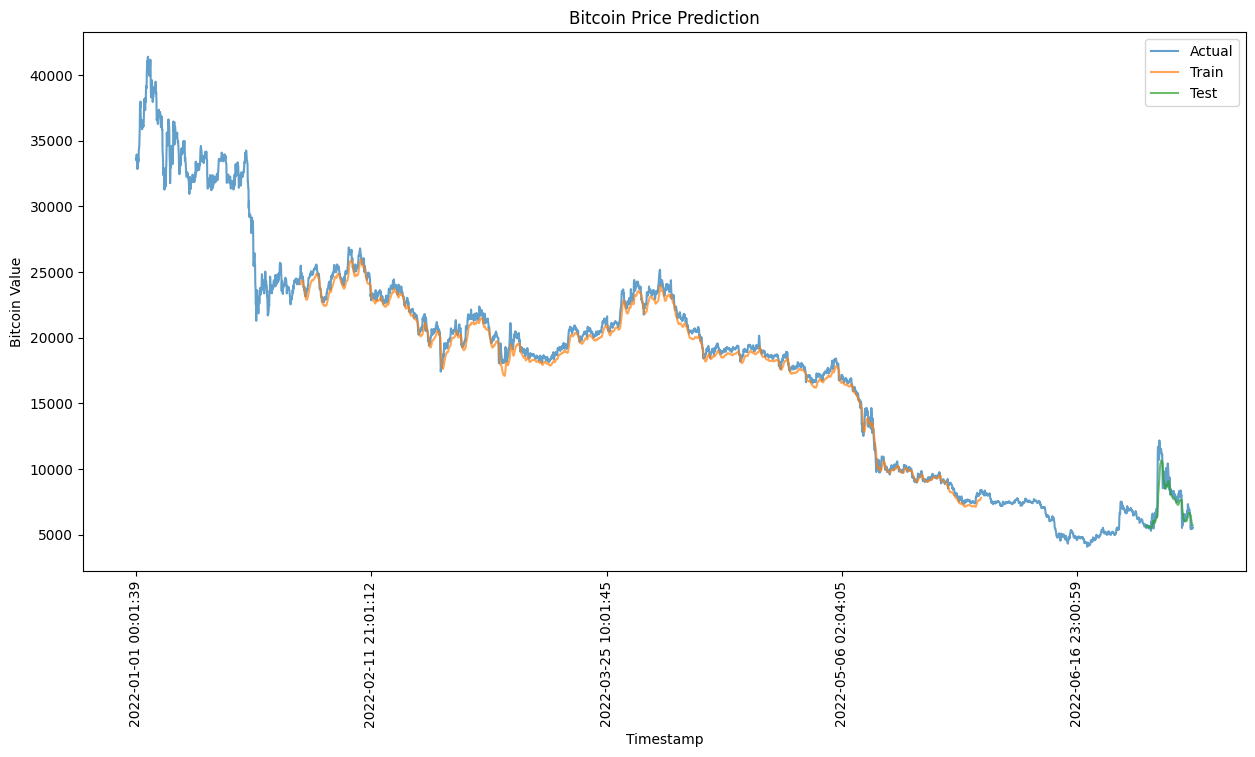

In [222]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, pred_col] = trainPredict

# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, pred_col] = testPredict

# contruct pandas dataframe for plotting
time_df = pd.DataFrame(data.index)
time_df['Actual'] = scaler.inverse_transform(dataset)[:,pred_col]
df1 = pd.DataFrame(trainPredictPlot[:,pred_col],columns=['Train'])
df2 = pd.DataFrame(testPredictPlot[:,pred_col],columns=['Test'])
time_df2 = pd.concat([time_df, df1, df2], axis=1, sort=False)
time_df2.set_index('timestamp',inplace=True)

# plot the output
fig, ax = plt.subplots(figsize=(15,7))
time_df2.plot(ax=ax,rot=90,alpha=0.7)
plt.xlabel('Timestamp')
plt.ylabel('Bitcoin Value')
plt.title('Bitcoin Price Prediction')
plt.savefig('./results/'+expr_name + '.png',bbox_inches = "tight")

In [221]:
print('-' * 50)
print('Experiment name:', expr_name)

print('-' * 50)
print('look_back days:', look_back/24)
print('lstm_layers:', lstm_layers)
print('epochs:', epochs)
print('batch_size:', batch_size)
print('dataset features', list(data.columns))


print('-' * 50)
print('Train Score: %.2f RMSE' % (trainScore_RMSE))
print('Test Score: %.2f RMSE' % (testScore_RMSE))

print('-' * 50)
print('Train Score: %.2f MAE' % (trainScore_MAE))
print('Test Score: %.2f MAE' % (testScore_MAE))

print('-' * 50)
print('Model summary:')
model.summary()

--------------------------------------------------
Experiment name: expr_1
--------------------------------------------------
look_back days: 29.166666666666668
lstm_layers: 32
epochs: 20
batch_size: 32
dataset features ['YFI price', 'YFI market cap', 'YFI total volume', 'BTC price', 'BTC market cap', 'BTC total volume', 'ETH price', 'ETH market cap', 'ETH total volume']
--------------------------------------------------
Train Score: 527.57 RMSE
Test Score: 845.48 RMSE
--------------------------------------------------
Train Score: 441.09 MAE
Test Score: 539.90 MAE
--------------------------------------------------
Model summary:
Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_25 (LSTM)              (None, 32)                4608      
                                                                 
 dense_24 (Dense)            (None, 1)                 33        
         